In [1]:
import vertica_python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandasql as ps
from pandasql import sqldf
import time
from datetime import date

In [2]:
def run_vrtc_query(query=None):
    
    """Queries data from Vertica and returns pandas dataframe"""

    # The user and password here are my own. 
    # The password will most probably be needed to be updated here, 
    # everytime I update it on my computer account. 
    vertica_conn = {
        'host': 'casual-prod-vertica-eon-lb.va2',
        'port': 5433,
        'user': 'alexanderloe',
        'password': 'SpainWC2022!',
        'database': 'calamari',}
    

    if not query:
        return
    try:
        connection = vertica_python.connect(**vertica_conn)
        with connection.cursor() as cursor:
            cursor.execute(query)
            names = [x[0] for x in cursor.description]
            return pd.DataFrame(cursor.fetchall(), columns=names)
        
    except Exception as err:
        print('Error: ', err)
        exit(1)

In [3]:
def load_data_from_vertica(sql):
    df = run_vrtc_query(sql)
    print("done vrtc_query")
    return df

In [4]:
# Set Pandas to display more columns as default
pd.options.display.max_columns=60

In [5]:
date_train_end = 20220915
query_data_for_clustering_check_features = f"""select * from analytics.agg_bb_daily_user_measures_snapshot as a
    where a.dim_date_gid = '{date_train_end}' limit 10;"""

In [11]:
t0= time.time()

data_for_clustering_check_features = load_data_from_vertica(query_data_for_clustering_check_features)

t1 = time.time()
print("\nTime elapsed: ", t1-t0)

print()
print(data_for_clustering_check_features.shape)
data_for_clustering_check_features.head(10)

done vrtc_query

Time elapsed:  63.38986110687256

(10, 155)


,dim_user_gid,dim_date_gid,date,is_in_DAU,top_platform,top_device,top_login_method,top_login_country,level,trstier,level_bracket,is_elite,is_reactviated_user,is_reactviated_payer,is_vip,is_notifications_enabled,number_of_platforms,number_of_devices,number_of_sessions,time_on_game_seconds,time_bingo_rooms_seconds,time_bingo_rooms_with_tournament_seconds,amount_of_push_notifications_received,last_login_date,last_gameplay_date,max_app_version,max_mobile_appversion,Is_fb_connected,Is_one_connected,Is_apple_connected,...,gross_sink_Specialty_Room_rounds,total_rounds_mode_6,Last_60D_Gross_Sink,Last_60D_Login_days,Last_60D_gameplay_days,Last_30D_rounds,Last_60D_rounds,Last_90D_rounds,is_free_trial_period,Life_Time_Login_Days,credits_finish_4,time_left_z,gems_balance_EOD,gems_spent,last_30D_gems_spent,last_90D_gems_spent,Lifetime_gems_spent,gems_transaction,last_30D_Gems_transactions,last_90D_gems_transactions,lifetime_gems_transactions,gems_purchased,last_30D_gems_purchased,last_90D_gems_purchased,gems_purchased_tx,last_30D_gems_purchased_tx,last_90D_gems_purchased_tx,lifetime_gems_purchased_tx,gems_inflow,lifetime_gems_purchased
0,558,20220915,2022-09-15,1,Facebook,PC,Facebook,UNITED STATES,109,1,lv_80_119,0,0,0,0,-1,1,1,1,696,282,282,0,2022-09-14 01:22:56.922,2022-09-14 01:34:34,5010,None,1,0,0,...,0,0,8747.0000,60,58,92,183,280,0,911,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,807,20220915,2022-09-15,1,Apple,iPad,Facebook Limited,AUSTRALIA,227,2,lv_200plus,0,0,0,0,0,1,1,2,643,273,273,0,2022-09-14 07:39:16.933,2022-09-14 07:56:13,5002,5002,0,0,0,...,0,0,34112.0000,56,45,209,488,739,0,1551,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,1064,20220915,2022-09-15,0,Web,PC,Facebook,UNITED KINGDOM,194,2,lv_170_199,0,0,0,0,-1,1,1,0,0,0,0,0,2022-09-13 11:47:49.668,2022-09-13 12:21:34,5000,None,0,0,0,...,0,0,5040.0000,11,10,40,66,117,0,1284,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,1517,20220915,2022-09-15,0,Facebook,PC,Facebook,UNITED STATES,177,2,lv_170_199,0,0,0,0,-1,1,1,0,0,0,0,0,2022-09-11 13:39:48.305,2022-09-11 14:06:20,5000,4612,0,0,0,...,0,0,13665.0000,27,25,71,189,265,0,1179,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,1621,20220915,2022-09-15,1,Google,Android Phone,Facebook,UNITED STATES,172,3,lv_170_199,1,0,0,0,1,1,1,1,187,0,0,0,2022-09-14 06:55:26.750,2022-09-14 07:37:22,5000,5000,1,0,0,...,0,0,141387.0000,58,40,350,757,1158,0,304,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5,1853,20220915,2022-09-15,0,Google,Android Phone,Facebook,UNITED KINGDOM,98,2,lv_80_119,0,0,0,0,1,1,1,0,0,0,0,0,2022-07-30 21:05:37.511,2022-07-30 21:39:27,4972,4972,0,0,0,...,0,0,5368.0000,3,3,0,35,35,0,391,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6,1940,20220915,2022-09-15,1,Google,Android Phone,Facebook,UNITED KINGDOM,278,5,lv_200plus,0,0,0,0,1,2,2,3,1541,512,512,0,2022-09-14 18:22:29.806,2022-09-14 17:09:39,5010,5000,1,0,0,...,0,0,41055.0000,60,58,116,210,312,0,2427,20,15,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
7,2080,20220915,2022-09-15,1,Apple,iPhone,Facebook Limited,UNITED STATES,256,2,lv_200plus,0,0,0,0,1,1,1,5,2070,797,797,0,2022-09-14 21:19:47.770,2022-09-14 21:58:26,5002,5002,0,0,0,...,0,0,37557.0000,60,60,414,690,1005,0,1967,18,12,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,2292,20220915,2022-09-15,1,Google,Android Phone,Facebook,UNITED STATES,223,2,lv_200plus,0,0,0,0,1,1,1,1,175,0,106,0,2022-09-14 23:50:48.524,2022-09-14 23:58:19,4992,4992,1,0,0,...,0,0,19440.0000,41,13,27,64,72,0,2104,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9,2375,20220915,2022-09-15,0,Apple,iPad,Facebook Limited,UNITED STAT

In [12]:
columns_names = data_for_clustering_check_features.columns.values.tolist()
check_words = ['login', 'First', 'first', 'install', 'Install', 'life', 'lifetime', 'date']
for item in columns_names:
    if any(word in item.split("_") for word in check_words): 
        print(item)

dim_date_gid
date
top_login_method
top_login_country
last_login_date
last_gameplay_date
distinct_login_channels
first_login_origin_type
first_login_origin_id
lifetime_gems_transactions
lifetime_gems_purchased_tx
lifetime_gems_purchased


In [5]:
date_train_end_format_full = "2022-09-15"
date_train_end = 20220915

date_target = 20220916

In [7]:
# The query for the data for the clustering
query_data_for_clustering = f"""select dim_user_gid,
    top_platform,
    level,
    trstier,
    level_bracket,
    is_elite,
    is_vip,
    datediff(day, last_login_date, '{date_train_end_format_full}') as llrecency,
    Lifetime_Revenue_Net,
    Last_30D_Revenue_Net,
    Last_90D_Revenue_Net,
    Last_30D_Transactions,
    Last_30D_Gross_Sink,
    Last_90D_Gross_Sink,
    Last_30D_Login_days,
    Last_90D_Login_days,
    credits_balance_EOD,
    coins_balance_EOD,
    number_of_bingo_rounds,
    Life_Time_Login_Days,
    total_rounds_mode_1,
    total_rounds_mode_2,
    total_rounds_mode_3,
    total_rounds_mode_4,
    total_rounds_mode_5,
    total_rounds_mode_6
    from analytics.agg_bb_daily_user_measures_snapshot as a
    where a.dim_date_gid = '{date_train_end}' and a.last_login_date <= '{date_train_end_format_full}'
    limit 5000000;"""


In [5]:
# An example for a target with numerical values 
query_target_revenue = f"""select dim_user_gid, revenue_converted_net
from blitz_all.core_transaction_purchase
where dim_date_gid = '{date_target}';"""

In [6]:
# An example for a target with discrete values 
query_target_level_ups = f"""select dim_user_gid, count(*) as level_ups
from blitz_all.blitz_level_up
where dim_date_gid = '{date_target}'
group by 1;"""

In [7]:
# An example for a target with binary values 
query_target_mode_number = f"""select dim_user_gid, round(avg(modenumber)) as typical_modenumber
from blitz.blitz_bingo_round_start
where dim_date_gid = '{date_target}' and modenumber >= 1
group by 1;"""

In [8]:
t0= time.time()

data_for_clustering = load_data_from_vertica(query_data_for_clustering)

t1 = time.time()
print("\nTime elapsed: ", t1-t0)

print()
print(data_for_clustering.shape)
data_for_clustering.head(10)

done vrtc_query

Time elapsed:  1056.6003980636597

(5000000, 26)


,dim_user_gid,top_platform,level,trstier,level_bracket,is_elite,is_vip,llrecency,Lifetime_Revenue_Net,Last_30D_Revenue_Net,...,credits_balance_EOD,coins_balance_EOD,number_of_bingo_rounds,Life_Time_Login_Days,total_rounds_mode_1,total_rounds_mode_2,total_rounds_mode_3,total_rounds_mode_4,total_rounds_mode_5,total_rounds_mode_6
0,953,Web,272.0,2.0,lv_200plus,0,0,1,0.0000,0.0000,...,36018.0,16136268.0,7,2335,0,0,3,3,1,0
1,1054,Google,226.0,4.0,lv_200plus,1,0,1,83.7783,12.8209,...,8009.0,1520319.0,32,903,0,32,0,0,0,0
2,1103,Google,168.0,2.0,lv_140_169,0,0,1,0.0000,0.0000,...,31133.0,7017099.0,0,1226,0,0,0,0,0,0
3,1147,Apple,485.0,4.0,lv_200plus,0,0,1,1196.0878,0.0000,...,26329.0,3637203.0,0,2492,0,0,0,0,0,0
4,1148,Facebook,227.0,2.0,lv_200plus,0,0,1,0.0000,0.0000,...,11769.0,45457627.0,15,2228,0,10,0,0,0,0
5,1962,Google,212.0,2.0,lv_200plus,0,0,2,3.8893,0.0000,...,32.0,10412.0,10,1810,3,7,0,0,0,0
6,2211,Apple,227.0,2.0,lv_200plus,0,0,1,0.0000,0.0000,...,5356.0,8769169.0,0,1886,0,0,0,0,0,0
7,2227,Apple,157.0,2.0,lv_140_169,0,0,29,0.0000,0.0000,...,11438.0,1344389.0,0,1157,0,0,0,0,0,0
8,2377,Apple,237.0,3.0,lv_200plus,1,0,1,925.9390,10.4930,...,35.0,436363.0,4,1748,4,0,0,0,0,0
9,2504,Google,119.0,2.0,lv_80_119,0,0,43,0.0000,0.0000,...,826.0,945770.0,0,602,0,0,0,0,0,0


In [10]:
data_for_clustering_5_million = data_for_clustering
data_for_clustering_5_million.to_pickle("Data/data_features_5_million.pkl")

In [23]:
data_for_clustering.to_pickle("data_for_clustering.pkl")

In [13]:
t0= time.time()

data_target_revenue = load_data_from_vertica(query_target_revenue)

t1 = time.time()
print("\nTime elapsed: ", t1-t0)

print()
print(data_target_revenue.shape)
data_target_revenue.head(10)

done vrtc_query

Time elapsed:  3.9297659397125244

(103211, 2)


,dim_user_gid,revenue_converted_net
0,5310,10.4930
1,12020,7.2559
2,12020,2.1712
3,12020,7.2559
4,19909,33.9933
5,20898,19.0053
6,21646,20.4730
7,21646,10.4930
8,25924,89.5930
9,27249,2.0930


In [24]:
data_target_revenue.to_pickle("Data/data_target_revenue.pkl")

In [12]:
t0= time.time()

data_target_level_ups = load_data_from_vertica(query_target_level_ups)

t1 = time.time()
print("\nTime elapsed: ", t1-t0)

print()
print(data_target_level_ups.shape)
data_target_level_ups.head(10)

done vrtc_query

Time elapsed:  4.745867967605591

(178623, 2)


,dim_user_gid,level_ups
0,1004631020,1
1,1004553200,1
2,1001694200,1
3,1004641280,2
4,1004319620,2
5,1004471300,2
6,1004473360,3
7,1003580440,1
8,4249480,1
9,6743080,1


In [23]:
data_target_level_ups.to_pickle("Data/data_target_level_ups.pkl")

In [11]:
t0= time.time()

data_target_mode_number = load_data_from_vertica(query_target_mode_number)

t1 = time.time()
print("\nTime elapsed: ", t1-t0)

print()
print(data_target_mode_number.shape)
data_target_mode_number.head(10)

done vrtc_query

Time elapsed:  66.112717628479

(714479, 2)


,dim_user_gid,typical_modenumber
0,600,5.0
1,800,1.0
2,1223,2.0
3,1646,3.0
4,1735,1.0
5,2191,2.0
6,2447,4.0
7,2472,3.0
8,2576,1.0
9,2717,4.0


In [22]:
data_target_mode_number.to_pickle("Data/data_target_mode_number.pkl")

### Getting first install date

In [70]:
query_first_install_date = f"""select UserId, First_Install_ts
from analytics.bb_user_profile limit 10000000;"""

In [71]:
t0= time.time()

data_install_date = load_data_from_vertica(query_first_install_date)

t1 = time.time()
print("\nTime elapsed: ", t1-t0)

done vrtc_query

Time elapsed:  898.1240041255951


In [72]:
print(data_install_date.shape)
data_install_date.head(10)

(10000000, 2)


,UserId,First_Install_ts
0,336,2010-10-15
1,366,2010-10-16
2,422,2010-10-17
3,451,2010-10-18
4,485,2010-10-18
5,487,2010-10-18
6,493,2010-10-19
7,514,2010-10-19
8,555,2010-10-20
9,563,2010-10-20


In [73]:
# Cleaning the data from non-date items by transforming them to NaN:
pd.to_datetime(data_install_date['First_Install_ts'], errors='coerce')

0         2010-10-15
1         2010-10-16
2         2010-10-17
3         2010-10-18
4         2010-10-18
             ...    
9999995   2011-05-30
9999996   2011-05-30
9999997   2011-05-30
9999998   2011-05-30
9999999   2011-05-30
Name: First_Install_ts, Length: 10000000, dtype: datetime64[ns]

In [74]:
# Checking if there are indeed NaN in the data: 
data_install_date.loc[data_install_date['First_Install_ts'].isnull()]

,UserId,First_Install_ts
24633,58780378,NaT
25952,58875802,NaT
26219,58896619,NaT
30745,58912285,NaT
30776,58914817,NaT
...,...,...
9969455,65370625,NaT
9992711,64144426,NaT
9992715,64144669,NaT
9992721,64145059,NaT


In [75]:
# Dropping the rows with NaN: 
data_install_date.dropna(inplace = True)

In [82]:
# Drop rows with dates that are after the data for clustering train date: 
date_train_end_int = date(*[int(k) for k in date_train_end_format_full.split("-")])
date_train_end_int_64 = np.datetime64(date_train_end_int)
data_install_date = data_install_date[data_install_date.First_Install_ts < date_train_end_int_64]

In [84]:
data_install_date.shape

(9988699, 2)

In [85]:
# Calculating the seniority of the users in the data, with the date_train_end being the limit day for the seniority:

seniority = []
user_ID = []

count = 0
for index, row in data_install_date.iterrows():
    if count%100000 == 0:
        print(count)
    if date_train_end_int > row["First_Install_ts"].date():
        delta = date_train_end_int - row["First_Install_ts"].date()
        seniority.append(delta.days)
        user_ID.append(row["UserId"])
    else:
        print("\nDate {} is after train end\n".format(row["First_Install_ts"].date()))
        
    count += 1

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000


In [86]:
# Adding the calculated seniority to the data frame: 
data_install_date["seniority"] = seniority

In [87]:
data_install_date.head(10)

,UserId,First_Install_ts,seniority
0,336,2010-10-15,4353
1,366,2010-10-16,4352
2,422,2010-10-17,4351
3,451,2010-10-18,4350
4,485,2010-10-18,4350
5,487,2010-10-18,4350
6,493,2010-10-19,4349
7,514,2010-10-19,4349
8,555,2010-10-20,4348
9,563,2010-10-20,4348


In [88]:
data_install_date.to_pickle("Data/data_install_date_and_seniority.pkl")

### Checking the relation between the user-id and the seniority

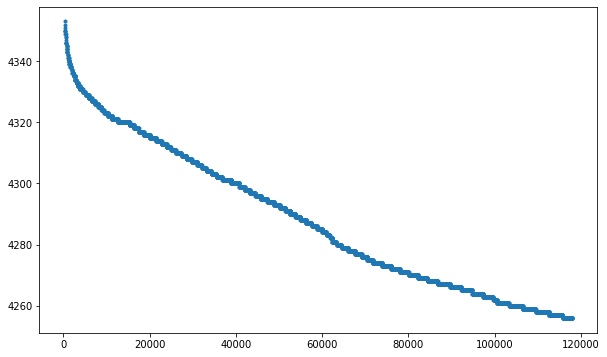

In [22]:
plt.figure(figsize = (10, 6))
plt.plot(user_ID[:5000], seniority[:5000], '.')
plt.show()

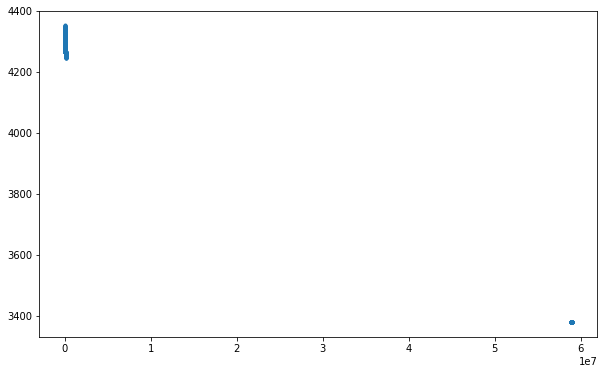

In [31]:
plt.figure(figsize = (10, 6))
plt.plot(user_ID[:7000], seniority[:7000], '.')
plt.show()

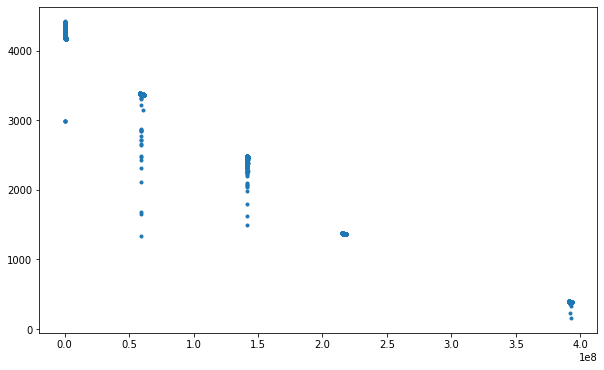

In [32]:
plt.figure(figsize = (10, 6))
plt.plot(user_ID, seniority, '.')
plt.show()

In [67]:
user_ID_seg = []
seniority_seg = []
for ind, user in enumerate(user_ID):
    if user < 150000000 and user > 140000000:
        user_ID_seg.append(user)
        seniority_seg.append(seniority[ind])


In [68]:
print(len(user_ID_seg))

150866


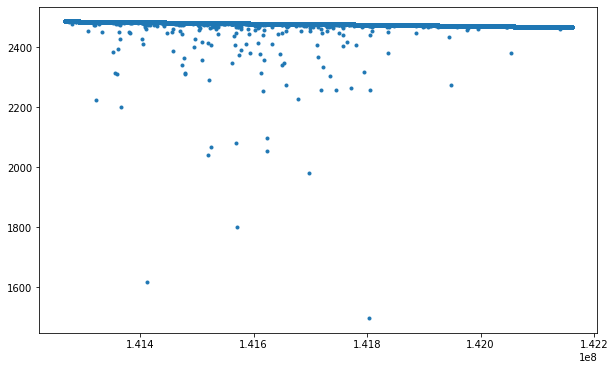

In [69]:
plt.figure(figsize = (10, 6))
plt.plot(user_ID_seg, seniority_seg, '.')
plt.show()

From the figures above, it seems that at the beginning of the app, there was a clear monotonously decreasing relation between the user-id and the seniority (as expected -> newer users with higher IDs have lower seniority).   
Later on it seems that for a given period of time, users received more random IDs within a certain range (hash values), and newer groups received random values at ranges with higher values (which explains the groupings, and the overall decreasing trend between the groups in the figure above of all the data). 